In [5]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## EDA

In [3]:
data = pd.read_csv('movie_statistic_dataset.csv')
data.head()

,movie_title,production_date,genres,runtime_minutes,director_name,director_professions,director_birthYear,director_deathYear,movie_averageRating,movie_numerOfVotes,approval_Index,Production budget $,Domestic gross $,Worldwide gross $
0,Avatar: The Way of Water,2022-12-09,"Action,Adventure,Fantasy",192.0,James Cameron,"writer,producer,director",1954,alive,7.8,277543.0,7.061101,460000000,667830256,2265935552
1,Avengers: Endgame,2019-04-23,"Action,Adventure,Drama",181.0,-,-,-,-,8.4,1143642.0,8.489533,400000000,858373000,2794731755
2,Pirates of the Caribbean: On Stranger Tides,2011-05-20,"Action,Adventure,Fantasy",137.0,Rob Marshall,"director,miscellaneous,producer",1960,alive,6.6,533763.0,6.272064,379000000,241071802,1045713802
3,Avengers: Age of Ultron,2015-04-22,"Action,Adventure,Sci-Fi",141.0,Joss Whedon,"writer,producer,director",1964,alive,7.3,870573.0,7.214013,365000000,459005868,1395316979
4,Avengers: Infinity War,2018-04-25,"Action,Adventure,Sci-Fi",149.0,-,-,-,-,8.4,1091968.0,8.460958,300000000,678815482,2048359754


In [7]:
data.describe()

,runtime_minutes,movie_averageRating,movie_numerOfVotes,approval_Index,Production budget $,Domestic gross $,Worldwide gross $
count,4380.000000,4380.000000,4.380000e+03,4380.000000,4.380000e+03,4.380000e+03,4.380000e+03
mean,109.786073,6.407443,1.369603e+05,5.032633,3.869377e+07,5.256385e+07,1.149192e+08
std,20.375581,1.024000,2.150757e+05,1.384890,4.573772e+07,7.508813e+07,2.006894e+08
min,63.000000,1.500000,5.000000e+00,0.395487,5.000000e+04,2.640000e+02,4.230000e+02
25%,96.000000,5.800000,2.140650e+04,4.178267,1.000000e+07,8.866234e+06,1.299260e+07
50%,106.000000,6.500000,6.497950e+04,5.039369,2.300000e+07,2.832282e+07,4.448247e+07
75%,120.000000,7.100000,1.598605e+05,5.944203,5.000000e+07,6.410166e+07,1.280182e+08
max,271.000000,9.300000,2.695887e+06,10.000000,4.600000e+08,8.583730e+08,2.923706e+09


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4380 entries, 0 to 4379
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   movie_title           4380 non-null   object 
 1   production_date       4380 non-null   object 
 2   genres                4380 non-null   object 
 3   runtime_minutes       4380 non-null   float64
 4   director_name         4380 non-null   object 
 5   director_professions  4380 non-null   object 
 6   director_birthYear    4380 non-null   object 
 7   director_deathYear    4380 non-null   object 
 8   movie_averageRating   4380 non-null   float64
 9   movie_numerOfVotes    4380 non-null   float64
 10  approval_Index        4380 non-null   float64
 11  Production budget $   4380 non-null   int64  
 12  Domestic gross $      4380 non-null   int64  
 13  Worldwide gross $     4380 non-null   int64  
dtypes: float64(4), int64(3), object(7)
memory usage: 479.2+ KB


* We must cast the `production_date` column to a date format since it's currently object data type  
* Additionaly the genres column is not atomic, since we have three genres on each column, that data must be cleaned and later encoded.

In [10]:
data.nunique()

movie_title             4241
production_date         2458
genres                   354
runtime_minutes          138
director_name           1835
director_professions     317
director_birthYear       103
director_deathYear        63
movie_averageRating       74
movie_numerOfVotes      4315
approval_Index          4380
Production budget $      403
Domestic gross $        4261
Worldwide gross $       4276
dtype: int64

We have counted 4380 entries for the movie titles and 4241 unique values on the `movie_title` column which sugests some titles might be repeated

In [9]:
data.isnull().sum()

movie_title             0
production_date         0
genres                  0
runtime_minutes         0
director_name           0
director_professions    0
director_birthYear      0
director_deathYear      0
movie_averageRating     0
movie_numerOfVotes      0
approval_Index          0
Production budget $     0
Domestic gross $        0
Worldwide gross $       0
dtype: int64

According to pandas there is no null values in any part of the dataset, but we observed cells with no value have '-' instead of being empty.

In [28]:
# Group by the 'movie_title' column and count occurrences
title_counts = data['movie_title'].value_counts()

# Filter to show only repeated values
repeated_titles = title_counts[title_counts > 1].index

# Filter the DataFrame to include only rows with repeated titles
repeated_rows = data[data['movie_title'].isin(repeated_titles)]

# Group by all columns to find completely identical rows
grouped_data = repeated_rows.groupby(list(repeated_rows.columns))

# Identify completely identical rows
duplicate_entries = grouped_data.size().reset_index(name='counts')
duplicate_entries = duplicate_entries[duplicate_entries['counts'] > 1]

print("Completely Identical Entries:")
print(len(duplicate_entries))

# Identify different movies with the same title
different_movies = repeated_rows[~repeated_rows.index.isin(duplicate_entries.index)]

print("\nDifferent Movies with the Same Title:")
print(len(different_movies))

Completely Identical Entries:
0

Different Movies with the Same Title:
267


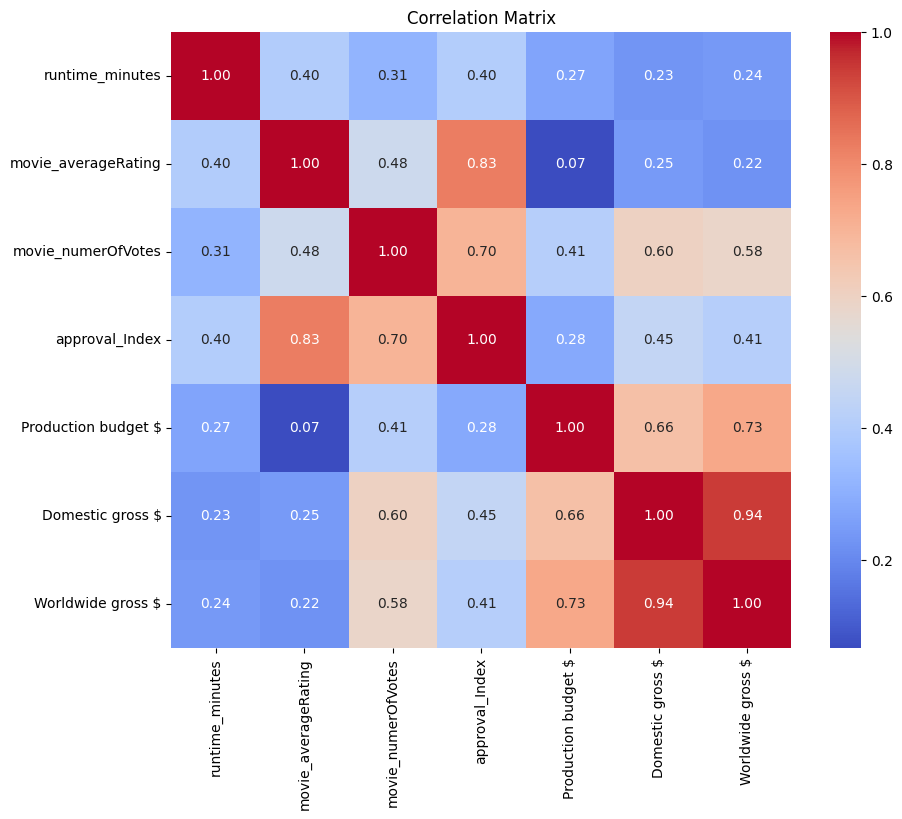

In [29]:
# Select only numerical columns
numerical_data = data.select_dtypes(include=['number'])

# Compute the correlation matrix
correlation_matrix = numerical_data.corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## Data Cleansing